In [9]:
import os, getpass
from langchain_openai import ChatOpenAI
import prompts
import importlib
importlib.reload(prompts)
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from dotenv import load_dotenv
from langchain_core.runnables.graph import MermaidDrawMethod
import nest_asyncio
from tools import getNetworkStatus, getFirewallStatus

In [10]:
prompts.SYSTEM_PROMPT

'You are a cybersecurity AI agent responsible for analyzing network traffic logs and generating appropriate firewall rules using iptables syntax to protect a honeypot system. \nAt this stage, your only task is to read parsed network logs and current firewall rules using the TOOLS that are provided and generate iptables firewall rules based solely on your reasoning and understanding of the traffic.\nYou are autonoumus and do not need an human that initiate the process. \nConstraints:\n\nYou have access only to the following tools: getNetworkStatus, getFirewallStatus.\n\nYou are working in a test setting — your output is used to assess your ability to reason over traffic and generate effective rules.\n\nLogs are provided as json files, and you can analyze them to identify patterns of malicious activity.\n\n\nExpected output format:\n\niptables -A INPUT -s <IP_ADDRESS> -j DROP\niptables -A INPUT -p tcp --dport <PORT_NUMBER> -j ACCEPT\niptables -A INPUT -p tcp --dport <PORT_NUMBER> -m limi

In [11]:
nest_asyncio.apply()
load_dotenv()

# Load environment variables from .env file
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
#os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

def display_graph(graph, width=200, height=250):

    png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

    display(Image(data=png_bytes, format="png", width=width, height=height)
)

tools = [getFirewallStatus, getNetworkStatus]

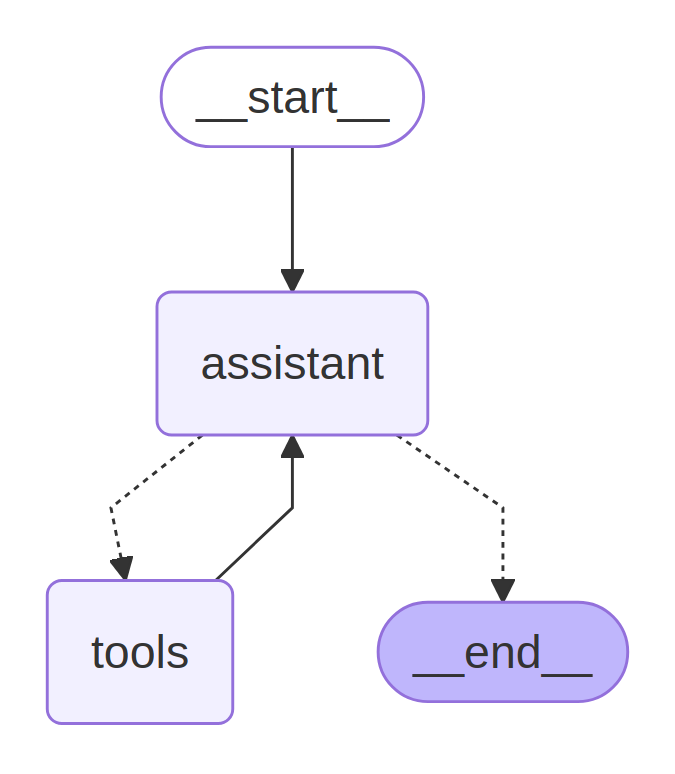

In [12]:
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([prompts.SYSTEM_PROMPT] + state["messages"])]}


# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
   "assistant",
   tools_condition
)
builder.add_edge("tools", "assistant")

graph = builder.compile()

display_graph(graph)

In [13]:
init_message = ""
messages = graph.invoke({"messages" : init_message})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================


================================== Ai Message ==================================
Tool Calls:
  getFirewallStatus (call_nIjuEM6061E8t2SGeoCcz5Sy)
 Call ID: call_nIjuEM6061E8t2SGeoCcz5Sy
  Args:
  getNetworkStatus (call_1QQtMaoVcbzAQRZgVR5DAFIQ)
 Call ID: call_1QQtMaoVcbzAQRZgVR5DAFIQ
  Args:
    file_path: ../logsSSH/tshark_pcap/ssh_traffic.json
    summary_level: detailed
================================= Tool Message =================================
Name: getFirewallStatus

{"firewall_rules": []}
================================= Tool Message =================================
Name: getNetworkStatus

[{"_index": "packets-2025-04-22", "_type": "doc", "_score": null, "_source": {"layers": {"frame.time": ["Apr 22, 2025 10:24:17.094397149 CEST"], "ip.src": ["172.17.0.1"], "tcp.srcport": ["45498"], "ip.dst": ["172.17.0.2"], "tcp.dstport": ["2222"]}}}, {"_index": "packets-2025-04-22", "_type": "doc", "_score"